# RL and Advanced DL: Домашнее задание 1
    Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

    Часть первая, с блекджеком и стратегиями
    Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

    Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
   * численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
   * туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
   * игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
   * игрок может совершать одно из двух действий:
        * hit  — взять ещё одну карту;
        * stand — не брать больше карт;
   * если сумма очков у игрока на руках больше 21, он проигрывает (bust);
   * если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
   * после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
   * в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
    
    Именно этот простейший вариант блекджека реализован в OpenAI Gym:
    https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

In [1]:
import gym

from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
rc('text', usetex = False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

C:\Users\artys\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Пример игры по примитивной стратегии

In [2]:
env = gym.make('Blackjack-v0', natural = True)

player, casino, ace_flg = env.reset()
done = False
result = 0

print('game_start:', (player, casino, ace_flg), done)
i = 1
while (player < 19) & (~done):
    # hit
    (player, casino, ace_flg), result, done, _ = env.step(1)
    print(f'step {i}:', (player, casino, ace_flg), result, done)
    i += 1

if result != -1:
    # stick
    print('final:', env.step(0))

env.close()

game_start: (17, 10, False) False
step 1: (27, 10, False) -1.0 True


# Task 1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

### Оценка функции V

In [3]:
total_episodes = 100000#500000
print_every = 100#500

In [4]:
def pi_strategy (state):
    if state[0] < 19:
        return 1
    else:
        return 0

In [5]:
def run_episode(env):
    state = env.reset()
    states, rewards = [state], [0]
    done = False
    while not done:
        pi_step = pi_strategy(state)
        state, reward, done, info = env.step(pi_step)
        states.append(state)
        rewards.append(reward)
        if done:
            break
    return states, rewards

def update_returns(R, states, rewards):
    g = 0
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        R[states[t]] = np.append(R[states[t]], g)
    return R

In [6]:
%%time
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.9

V = defaultdict(lambda: 0)
R = defaultdict(lambda: np.zeros(0))

avg_reward_list = []

for _ in range(total_episodes):
    states, rewards = run_episode(env)
    avg_reward_list.append(rewards[-1])
    R = update_returns(R, states, rewards)

for state in R.keys():
    V[state] = np.mean(R[state])

env.close()

Wall time: 20.4 s


Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.18417


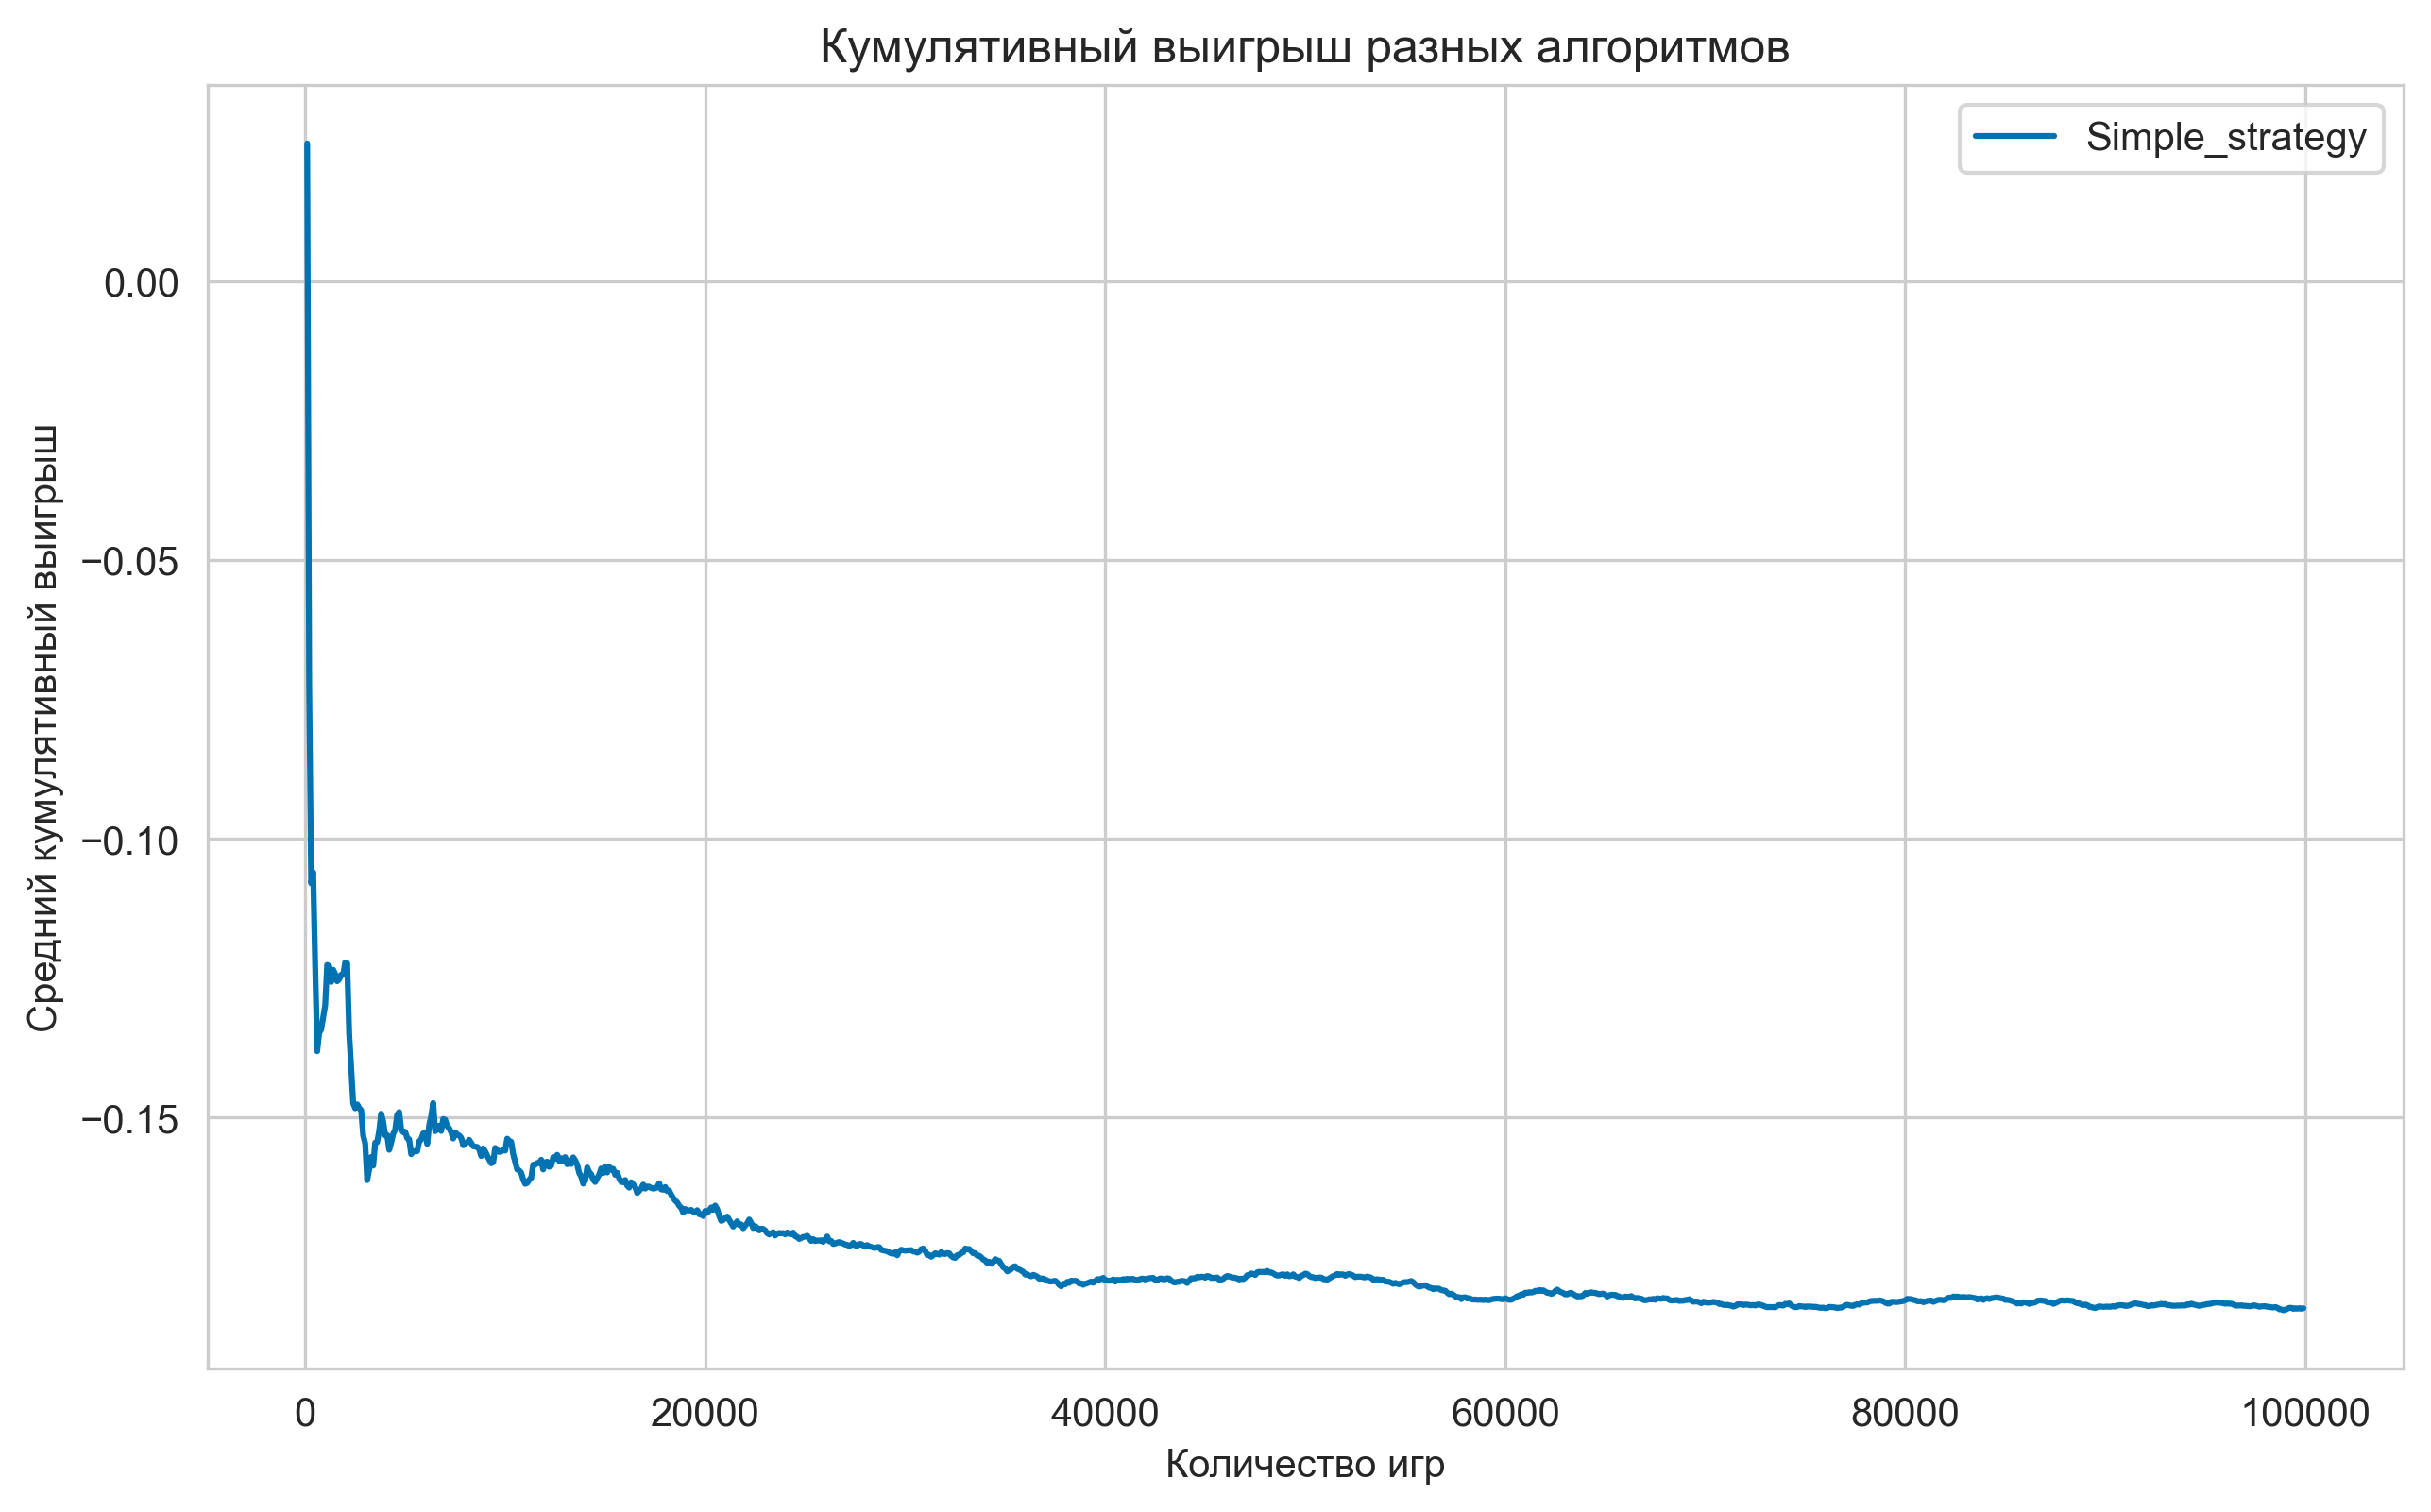

In [7]:
def print_cum_avg_rewards(total_episodes, avg_reward_lists, algo_names, print_every):
    
    print(f'Данные о среднем выигрыше по всем сыгранным {total_episodes} играм')

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_title('Кумулятивный выигрыш разных алгоритмов')
    ax.set_xlabel('Количество игр')
    ax.set_ylabel('Средний кумулятивный выигрыш')
    
    for i, name in enumerate(algo_names):
        print(f'{name}:', np.mean(avg_reward_lists[i]))

        mean_cum_rewards = np.true_divide( np.nancumsum(avg_reward_lists[i]), np.arange(1, len(avg_reward_lists[i])+1) )

        ax.plot(np.arange(1, len(mean_cum_rewards)+1)[print_every::print_every], mean_cum_rewards[print_every::print_every], label=name)

    ax.legend()
    plt.show()
    
print_cum_avg_rewards(total_episodes = total_episodes, avg_reward_lists = [avg_reward_list], algo_names = ['Simple_strategy'], print_every=print_every)

### Оценка функции Q

In [8]:
def run_episode_actions(env, pi=None, eps=0.0):
    state = env.reset()
    if pi is None:
        pi_step = pi_strategy(state)
    else:
        pi_step = pi[state]
    next_action = pi_step if np.random.rand() > eps else np.random.randint(env.action_space.n)
    states, actions, rewards = [state], [next_action], [0]
    done = False
    
    while not done:
        state, reward, done, info = env.step(next_action)
        if pi is None:
            pi_step = pi_strategy(state)
        else:
            pi_step = pi[state]
        next_action = pi_step if np.random.rand() > eps else np.random.randint(env.action_space.n)
        states.append(state)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
            
    return states, actions, rewards


def update_returns_actions(R, states, actions, rewards, gamma=1.0):
    g = 0
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        R[states[t]][actions[t]] = np.append(R[states[t]][actions[t]], g)
    return R

C:\Users\artys\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\artys\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.207535


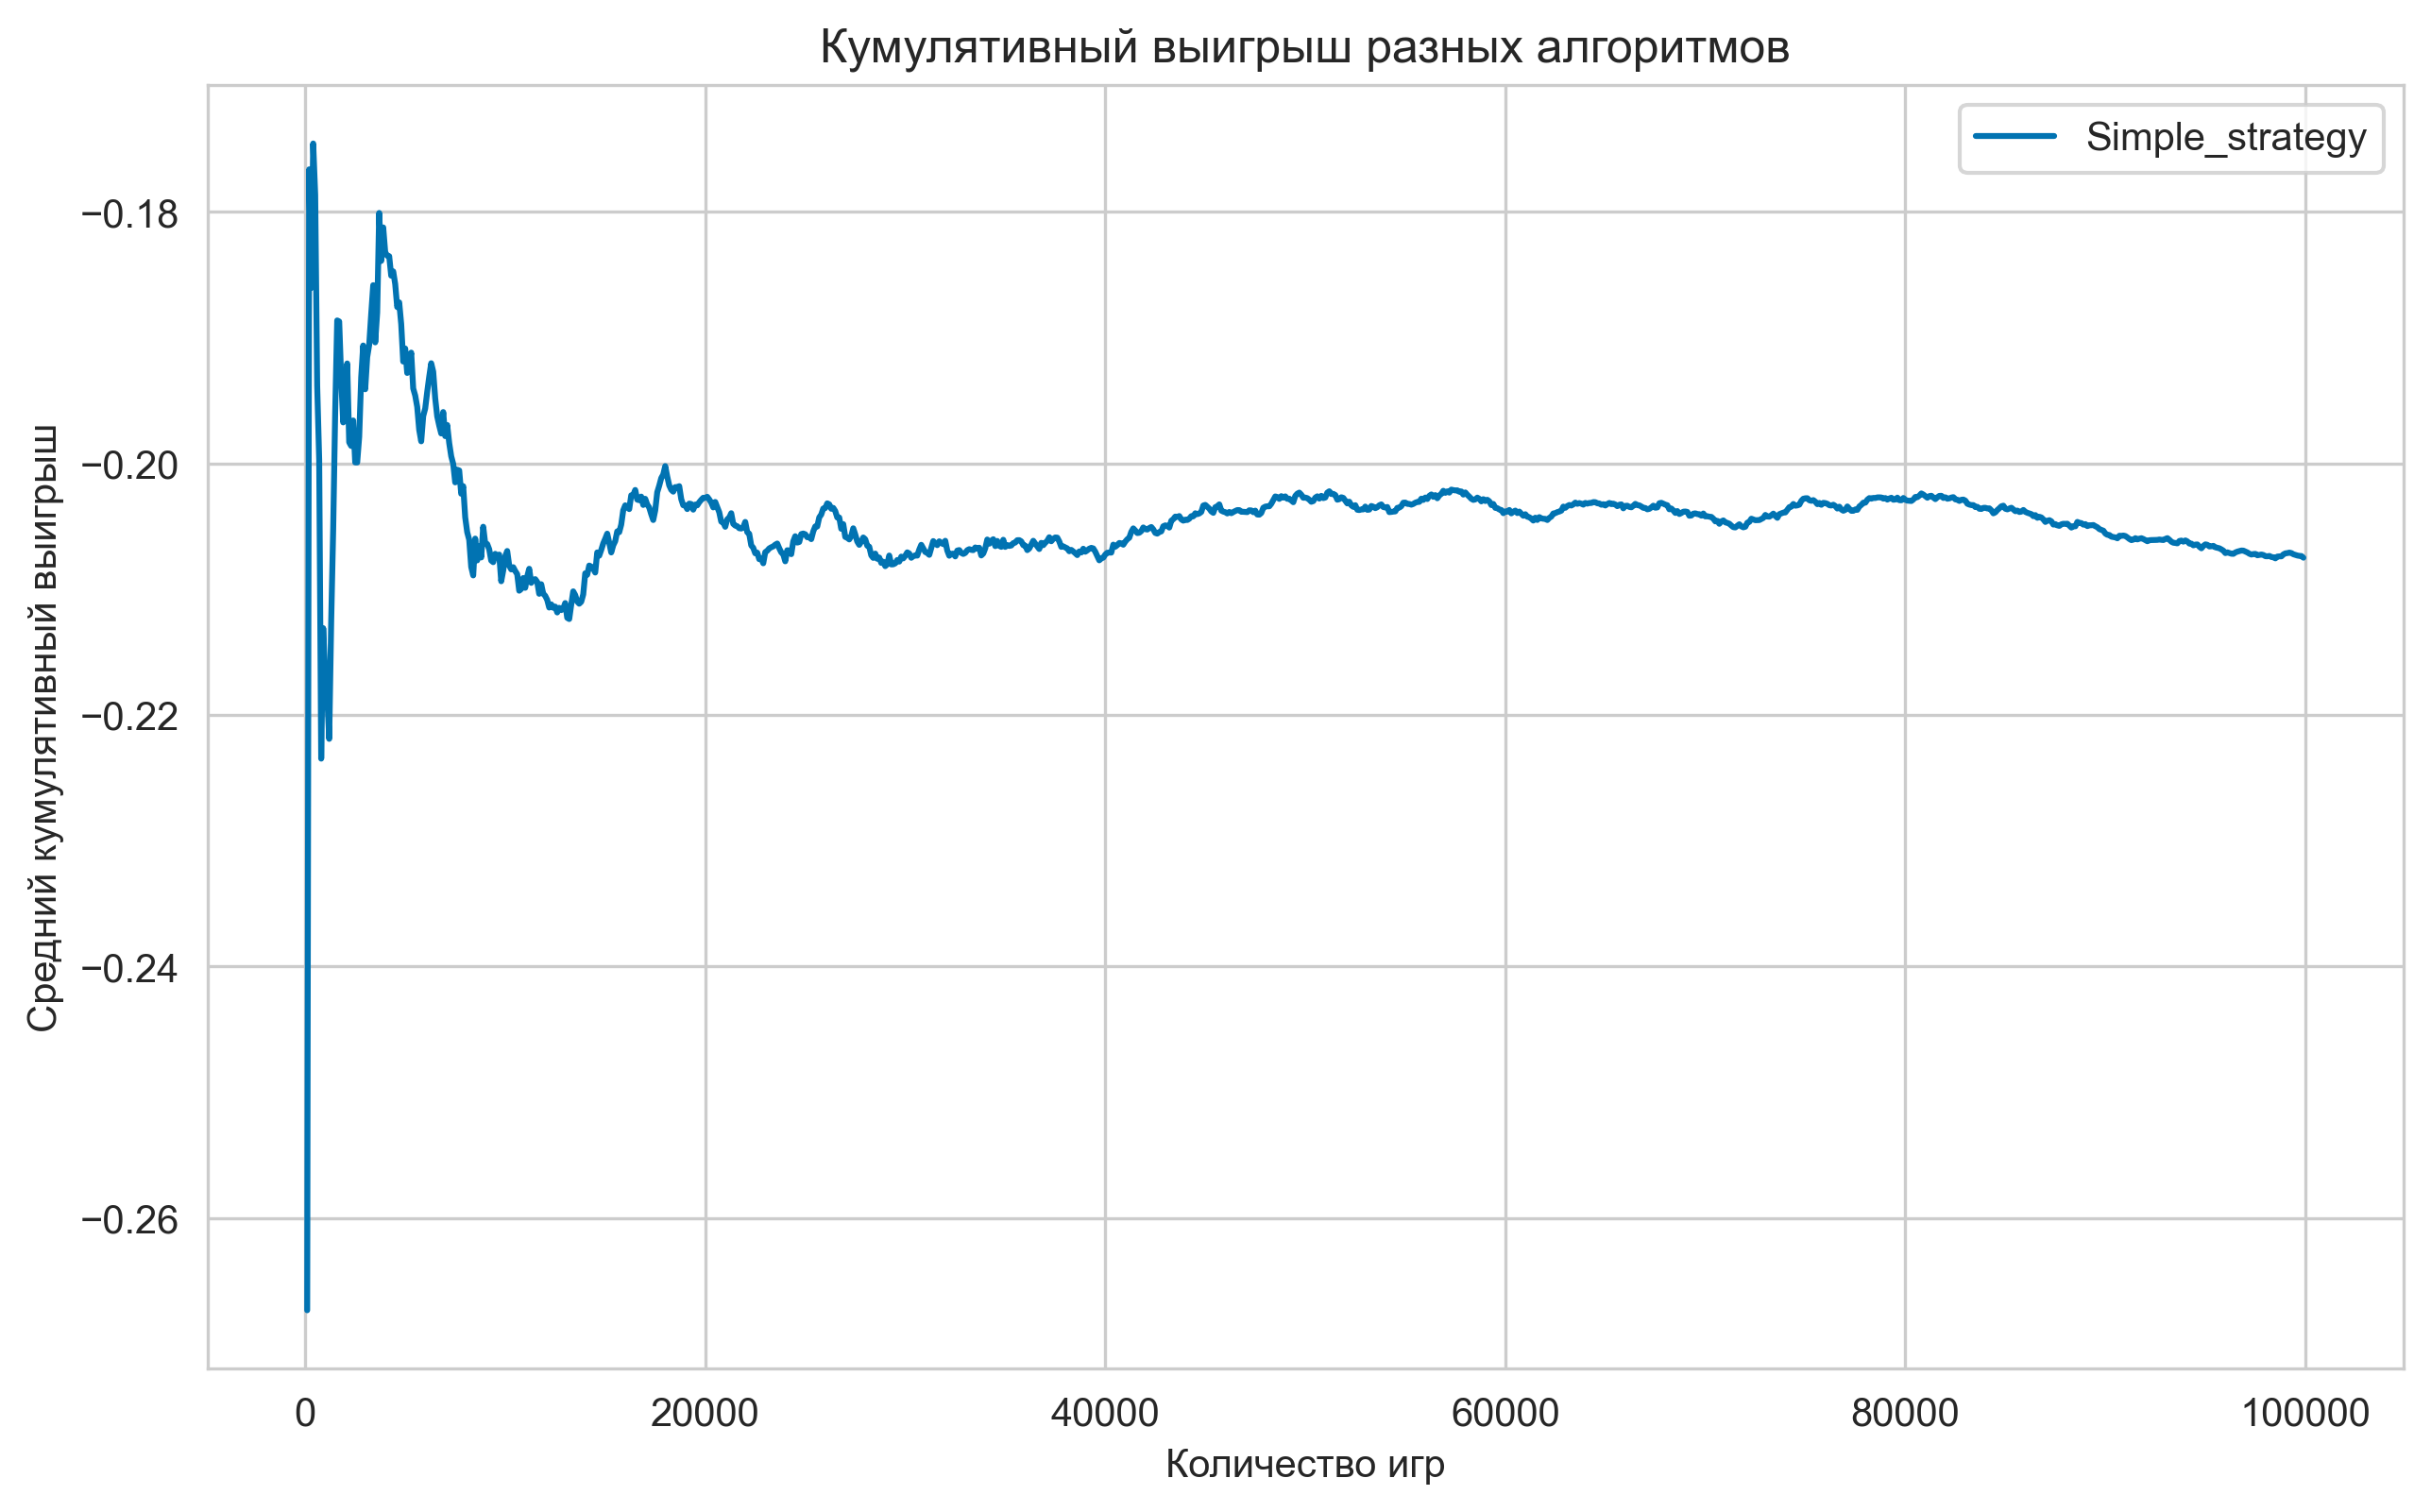

Wall time: 17.8 s


In [9]:
%%time
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.9

R = defaultdict(lambda: [[] for _ in range(env.action_space.n)])
avg_reward_list = []

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi=None, eps=0.1)
    avg_reward_list.append(rewards[-1])
    R = update_returns_actions(R, states, actions, rewards, gamma=gamma)

Q = defaultdict(lambda: np.zeros(env.action_space.n))
for state in R.keys():
    for action in range(env.action_space.n):
        Q[state][action] = np.mean(R[state][action])

env.close()

print_cum_avg_rewards(total_episodes = total_episodes, avg_reward_lists = [avg_reward_list], algo_names = ['Simple_strategy'], print_every=print_every)

# Task2

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

### Monte-Carlo control с on-policy исследованием

In [10]:
def compute_policy_by_Q(env, Q, gamma=1.0):
    new_pi = defaultdict(lambda: 0)
    for state in Q.keys():
        new_pi[state] = np.argmax(Q[state])
    return new_pi

In [11]:
def get_Q_by_R(R, nA, Q_default=None):
    if Q_default is not None:
        Q = Q_default
    else:
        Q = defaultdict(lambda: np.zeros(nA))
    for state in R.keys():
        for action in range(nA):
            Q[state][action] = np.mean(R[state][action])
    return Q

In [12]:
%%time
def MC_control_on_policy(env = gym.make('Blackjack-v0', natural=True), init_episodes = 10, total_episodes = 1000, gamma = 0.9):
    
    R = defaultdict(lambda: [[] for _ in range(env.action_space.n)])
    avg_reward_list = []

    for i in range(init_episodes):
#         if i % print_every == 0:
#             clear_output(wait=True)
#             print('Building model using Mone-Carlo on policy control...')
#             print('Initialization...')
#             print(f'Step {i}/{init_episodes}')
        states, actions, rewards = run_episode_actions(env, pi=None, eps=0.1)
        avg_reward_list.append(np.sum(rewards))
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)

    Q = None
    Q = get_Q_by_R(R, env.action_space.n, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)

    for i in range(total_episodes):
        if i % print_every == 0:
            clear_output(wait=True)
            print('Building model using Mone-Carlo on policy control...')
            print(f'Step {i}/{total_episodes}')
        states, actions, rewards = run_episode_actions(env, pi=pi, eps=0.1)
        avg_reward_list.append(np.sum(rewards))
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)
        Q = get_Q_by_R(R, env.action_space.n, Q_default=Q)
        pi = compute_policy_by_Q(env, Q)

    env.close()
    
    return Q, pi, avg_reward_list[init_episodes:]

MC_on_Q, MC_on_pi, MC_on_avg_reward_list = MC_control_on_policy(env = gym.make('Blackjack-v0', natural=True),  
                                                                init_episodes = 10, 
                                                                total_episodes = total_episodes, 
                                                                gamma = 0.9)

Building model using Mone-Carlo on policy control...
Step 99900/100000
Wall time: 19min 24s


### Monte-Carlo control с off-policy исследованием

In [13]:
def update_lists(s, a, g, w, Q, C):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    return Q, C

def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, nA, epsilon=0.1, gamma=1.0):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA

    # Обновляем функции для последнего хода
    Q, C = update_lists(states[-1], actions[-1], g, w, Q, C)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[states[t+1]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        Q, C = update_lists(states[t], actions[t], g, w, Q, C)
    return Q, C

In [14]:
%%time
def MC_control_off_policy(env = gym.make('Blackjack-v0', natural=True), 
                          total_episodes = 1000, 
                          gamma = 0.9):

    
    R = defaultdict(lambda: [[] for _ in range(env.action_space.n)])
    Q = None
    Q = get_Q_by_R(R, env.action_space.n, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    avg_reward_list = []

    for i in range(total_episodes):
        if i % print_every == 0:
            clear_output(wait=True)
            print('Building model using Mone-Carlo off policy control...')
            print(f'Step {i}/{total_episodes}')
        states, actions, rewards = run_episode_actions(env, pi=pi, eps=0.1)
        avg_reward_list.append(rewards[-1])
        Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, env.action_space.n, gamma=gamma)
        pi = compute_policy_by_Q(env, Q)

    env.close()
    
    return Q, pi, avg_reward_list

MC_off_Q, MC_off_pi, MC_off_avg_reward_list = MC_control_off_policy(env = gym.make('Blackjack-v0', natural=True), 
                                                                    total_episodes = total_episodes, 
                                                                    gamma = 0.9)

Building model using Mone-Carlo off policy control...
Step 99900/100000
Wall time: 3min 17s


### TD-обучение: on-policy (Sarsa)

In [15]:
def Sarsa_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    rewards = []
    env.reset()
    state, action = env._get_obs(), pi[env._get_obs()] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
    done = False
    while not done:
        _, reward, done, info = env.step(action)
        rewards.append(reward)
        state_prime, action_prime = env._get_obs(), pi[env._get_obs()] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[state][action] = Q[state][action] + alpha * (reward + gamma * Q[state_prime][action_prime] - Q[state][action])
        state, action = state_prime, action_prime
        
    return Q, rewards

In [16]:
%%time
def TD_on_policy_SARSA(env = gym.make('Blackjack-v0', natural=True),
                       total_episodes = 1000, 
                       gamma = 0.9,
                       alpha=0.005
                      ):
    
    R = defaultdict(lambda: [[] for _ in range(env.action_space.n)])
    Q = None
    Q = get_Q_by_R(R, env.action_space.n, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)
    avg_reward_list = []

    for n in range(1, total_episodes+1):
        if n % print_every == 0:
            clear_output(wait=True)
            print('Building model using SARSA...')
            print(f'Step {n}/{total_episodes}')
        Q, rewards = Sarsa_learning_episode(env, pi, Q, alpha=alpha, epsilon= 1. / (np.log(n)+1) , gamma=gamma)
        avg_reward_list.append(rewards[-1])
        pi = compute_policy_by_Q(env, Q)

    env.close()
    
    return Q, pi, avg_reward_list

SARSA_Q, SARSA_pi, SARSA_avg_reward_list = TD_on_policy_SARSA(env = gym.make('Blackjack-v0', natural=True), 
                                                              total_episodes = total_episodes, 
                                                              gamma = 0.9,
                                                              alpha=0.005
                                                             )

Building model using SARSA...
Step 100000/100000
Wall time: 3min 39s


## TD-обучение: off-policy (Q-обучение)

In [17]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    rewards = []
    env.reset()
    state, action = env._get_obs(), pi[env._get_obs()] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
    done = False
    while not done:
        _, reward, done, info = env.step(action)
        rewards.append(reward)
        state_prime, action_prime = env._get_obs(), pi[env._get_obs()] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max( Q[state_prime] ) - Q[state][action])
        state, action = state_prime, action_prime
        
    return Q, rewards

In [18]:
%%time
def TD_off_policy_Qlearning(env = gym.make('Blackjack-v0', natural=True), 
                            total_episodes = 1000, 
                            gamma = 0.9,
                            alpha=0.005
                            ):

    R = defaultdict(lambda: [[] for _ in range(env.action_space.n)])
    Q = None
    Q = get_Q_by_R(R, env.action_space.n, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)
    avg_reward_list = []

    for n in range(1, total_episodes+1):
        if n % print_every == 0:
            clear_output(wait=True)
            print('Building model Q-learning...')
            print(f'Step {n}/{total_episodes}')
        Q, rewards = Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= 0.1, gamma=gamma)
        avg_reward_list.append(rewards[-1])
        pi = compute_policy_by_Q(env, Q)

    env.close()
    
    return Q, pi, avg_reward_list

Qlearn_Q, Qlearn_pi, Qlearn_avg_reward_list = TD_off_policy_Qlearning(env = gym.make('Blackjack-v0', natural=True), 
                                                                      total_episodes = total_episodes, 
                                                                      gamma = 0.9,
                                                                      alpha=0.005
                                                                     )

Building model Q-learning...
Step 100000/100000
Wall time: 3min 37s


## Task 3

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.207535
MC_on_policy: -0.07407
MC_off_policy: -0.118025
SARSA: -0.125795
Q-learning: -0.12279


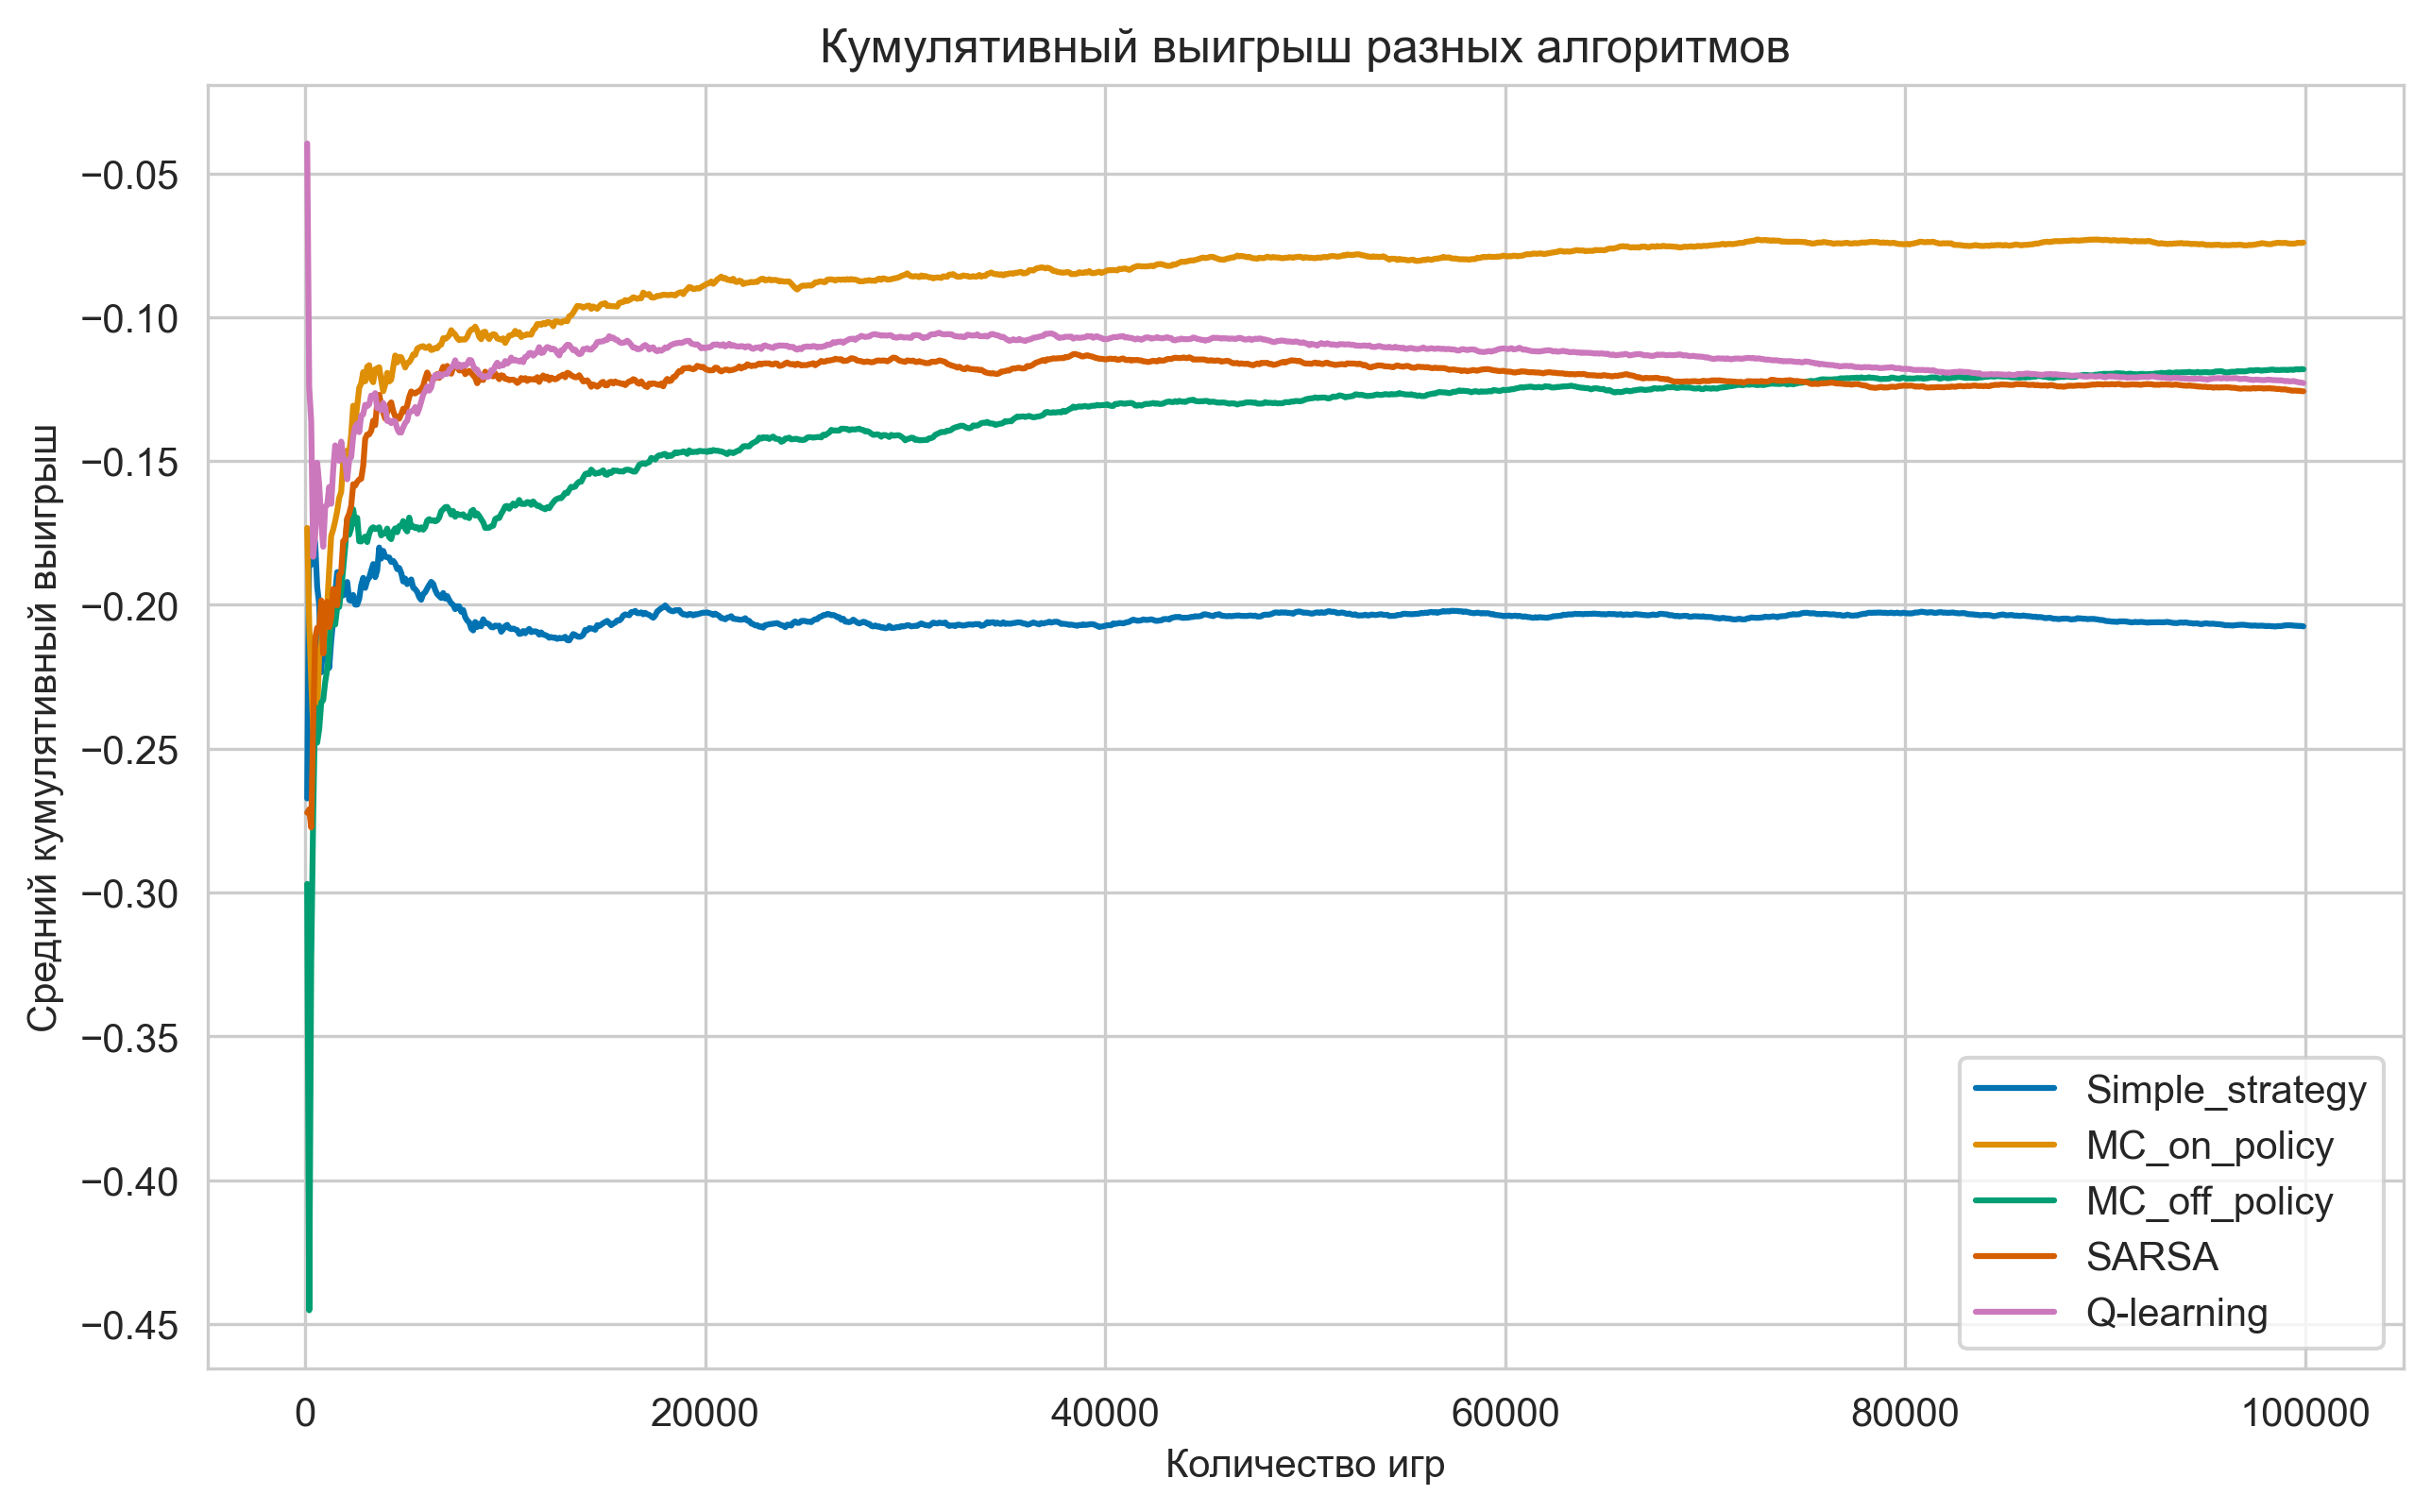

In [19]:
print_cum_avg_rewards(total_episodes = total_episodes, 
                      avg_reward_lists = [avg_reward_list,
                                          MC_on_avg_reward_list,
                                          MC_off_avg_reward_list,
                                          SARSA_avg_reward_list,
                                          Qlearn_avg_reward_list
                                         ], 
                      algo_names = ['Simple_strategy',
                                    'MC_on_policy',
                                    'MC_off_policy',
                                    'SARSA',
                                    'Q-learning'
                                   ],
                      print_every = print_every
                     )

In [20]:
%%time
SARSA_Q_new, SARSA_pi_new, SARSA_avg_reward_list_new = TD_on_policy_SARSA(env = gym.make('Blackjack-v0', natural=True), 
                                                                          total_episodes = total_episodes, 
                                                                          gamma = 0.9,
                                                                          alpha=0.01
                                                                         )
Qlearn_Q_new, Qlearn_pi_new, Qlearn_avg_reward_list_new = TD_off_policy_Qlearning(env = gym.make('Blackjack-v0', natural=True), 
                                                                                  total_episodes = total_episodes, 
                                                                                  gamma = 0.9,
                                                                                  alpha=0.01
                                                                                 )

Building model Q-learning...
Step 100000/100000
Wall time: 6min 45s


Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.207535
MC_on_policy: -0.07407
MC_off_policy: -0.118025
SARSA, gamma=0.9, alpha=0.005: -0.125795
SARSA, gamma=0.9, alpha=0.01: -0.126255
Q-learning, gamma=0.9, alpha=0.005: -0.12279
Q-learning, gamma=0.9, alpha=0.01: -0.13912


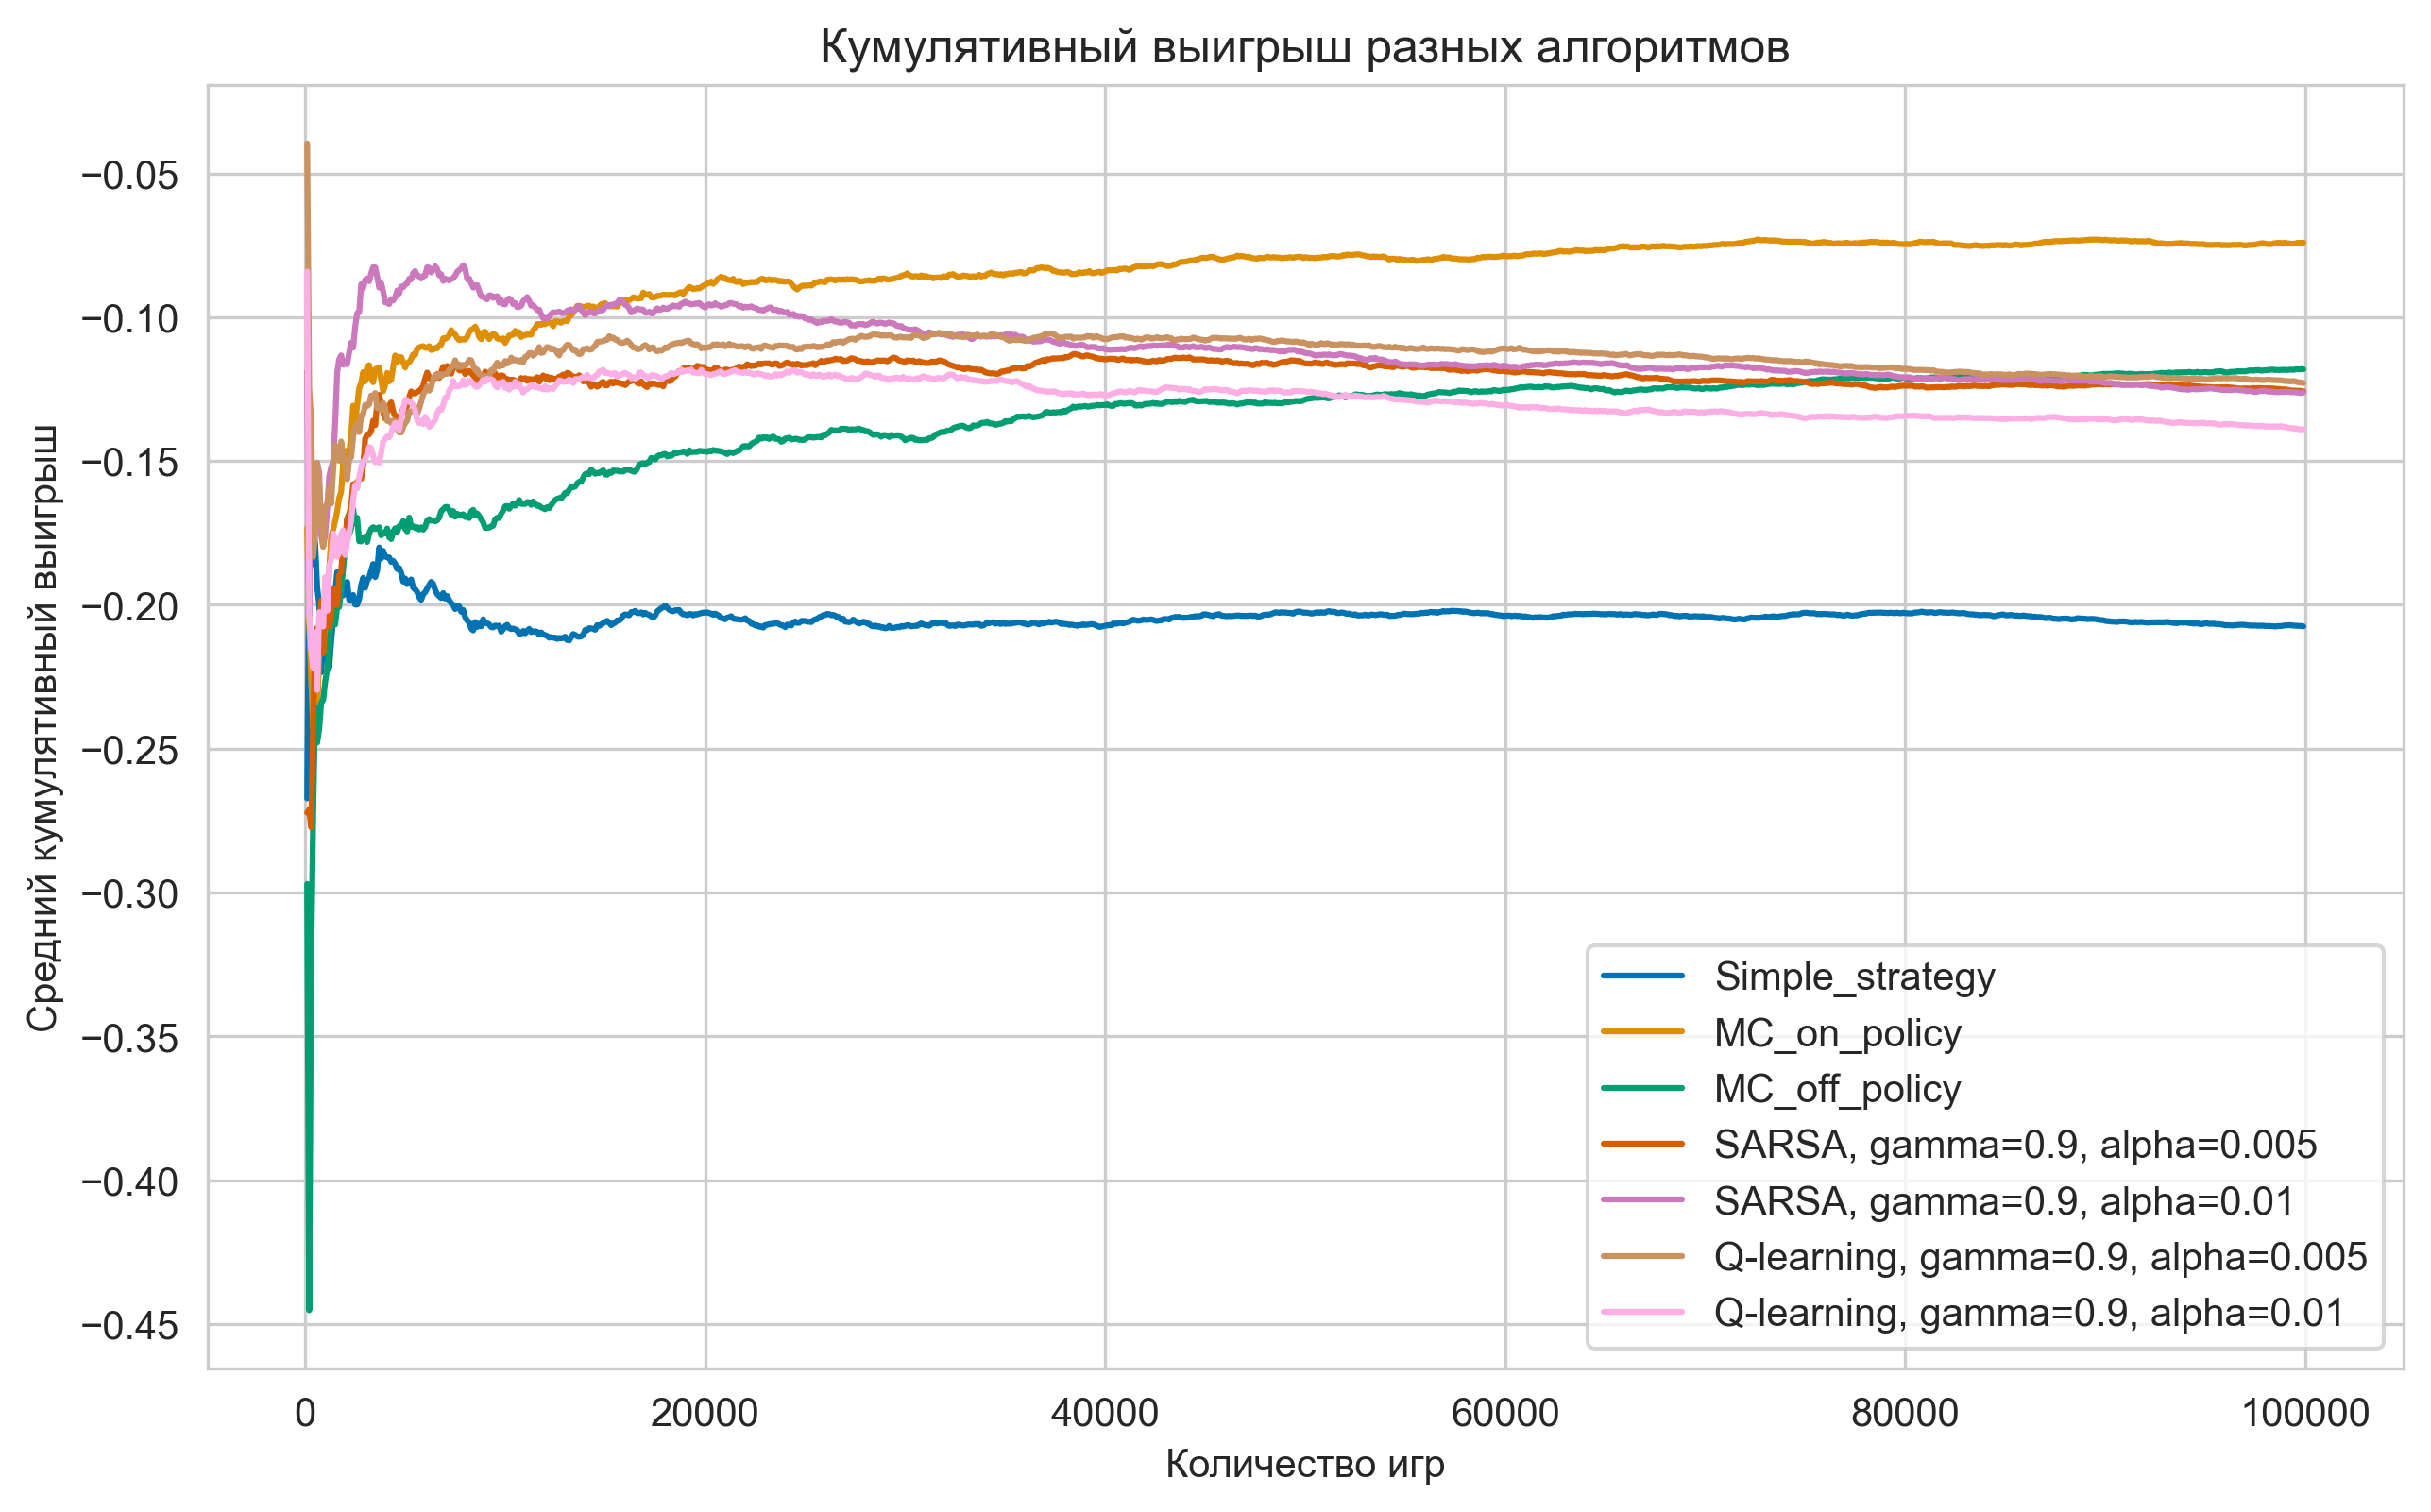

In [21]:
print_cum_avg_rewards(total_episodes = total_episodes, 
                      avg_reward_lists = [avg_reward_list,
                                          MC_on_avg_reward_list,
                                          MC_off_avg_reward_list,
                                          SARSA_avg_reward_list,
                                          SARSA_avg_reward_list_new,
                                          Qlearn_avg_reward_list,
                                          Qlearn_avg_reward_list_new,
                                          
                                         ], 
                      algo_names = ['Simple_strategy',
                                    'MC_on_policy',
                                    'MC_off_policy',
                                    'SARSA, gamma=0.9, alpha=0.005',
                                    'SARSA, gamma=0.9, alpha=0.01',
                                    'Q-learning, gamma=0.9, alpha=0.005',
                                    'Q-learning, gamma=0.9, alpha=0.01',
                                   ],
                      print_every = print_every
                     )

# Часть вторая, удвоенная
    В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
   * double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

## Task 4

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [22]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_v1(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        
        elif action == 2:
            done = True
            # player takes card
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                # dealer takes cards
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()
    
    
gym.envs.toy_text.blackjack.BlackjackEnv_v1 = BlackjackEnv_v1
if 'Blackjack-v1' in registry.env_specs:
    del registry.env_specs['Blackjack-v1']
    
register(
    id='Blackjack-v1',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnv_v1',
)

## Task 5

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [23]:
%%time
MC_on_Q_v1, MC_on_pi_v1, MC_on_avg_reward_list_v1 = MC_control_on_policy(env = gym.make('Blackjack-v1', natural=True), 
                                                                         init_episodes = 10, 
                                                                         total_episodes = total_episodes, 
                                                                         gamma = 0.1
                                                                        )

Building model using Mone-Carlo on policy control...
Step 99900/100000
Wall time: 27min 47s


In [24]:
%%time
MC_off_Q_v1, MC_off_pi_v1, MC_off_avg_reward_list_v1 = MC_control_off_policy(env = gym.make('Blackjack-v1', natural=True), 
                                                                             total_episodes = total_episodes, 
                                                                             gamma = 0.1
                                                                            )

Building model using Mone-Carlo off policy control...
Step 99900/100000
Wall time: 3min 16s


In [25]:
%%time
SARSA_Q_v1, SARSA_pi_v1, SARSA_avg_reward_list_v1 = TD_on_policy_SARSA(env = gym.make('Blackjack-v1', natural=True), 
                                                                       total_episodes = total_episodes, 
                                                                       gamma = 0.1,
                                                                       alpha=0.005
                                                                      )

Building model using SARSA...
Step 100000/100000
Wall time: 3min 22s


In [26]:
%%time
Qlearn_Q_v1, Qlearn_pi_v1, Qlearn_avg_reward_list_v1 = TD_off_policy_Qlearning(env = gym.make('Blackjack-v1', natural=True), 
                                                                               total_episodes = total_episodes, 
                                                                               gamma = 0.1,
                                                                               alpha=0.005
                                                                              )

Building model Q-learning...
Step 100000/100000
Wall time: 3min 20s


In [27]:
%%time
SARSA_Q_new_v1, SARSA_pi_new_v1, SARSA_avg_reward_list_new_v1 = TD_on_policy_SARSA(env = gym.make('Blackjack-v1', natural=True), 
                                                                                   total_episodes = total_episodes, 
                                                                                   gamma = 0.1,
                                                                                   alpha=0.01
                                                                                  )

Building model using SARSA...
Step 100000/100000
Wall time: 3min 20s


In [28]:
%%time
Qlearn_Q_new_v1, Qlearn_pi_new_v1, Qlearn_avg_reward_list_new_v1 = TD_off_policy_Qlearning(env = gym.make('Blackjack-v1', natural=True), 
                                                                                           total_episodes = total_episodes, 
                                                                                           gamma = 0.1,
                                                                                           alpha=0.01
                                                                                          )

Building model Q-learning...
Step 100000/100000
Wall time: 3min 16s


Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.207535
MC_on_policy_v1: -0.092855
MC_off_policy_v1: -0.105105
SARSA_v1, gamma=0.9, alpha=0.005: -0.11712
SARSA_v1, gamma=0.9, alpha=0.01: -0.11142
Q-learning_v1, gamma=0.9, alpha=0.005: -0.121225
Q-learning_v1, gamma=0.9, alpha=0.01: -0.12101


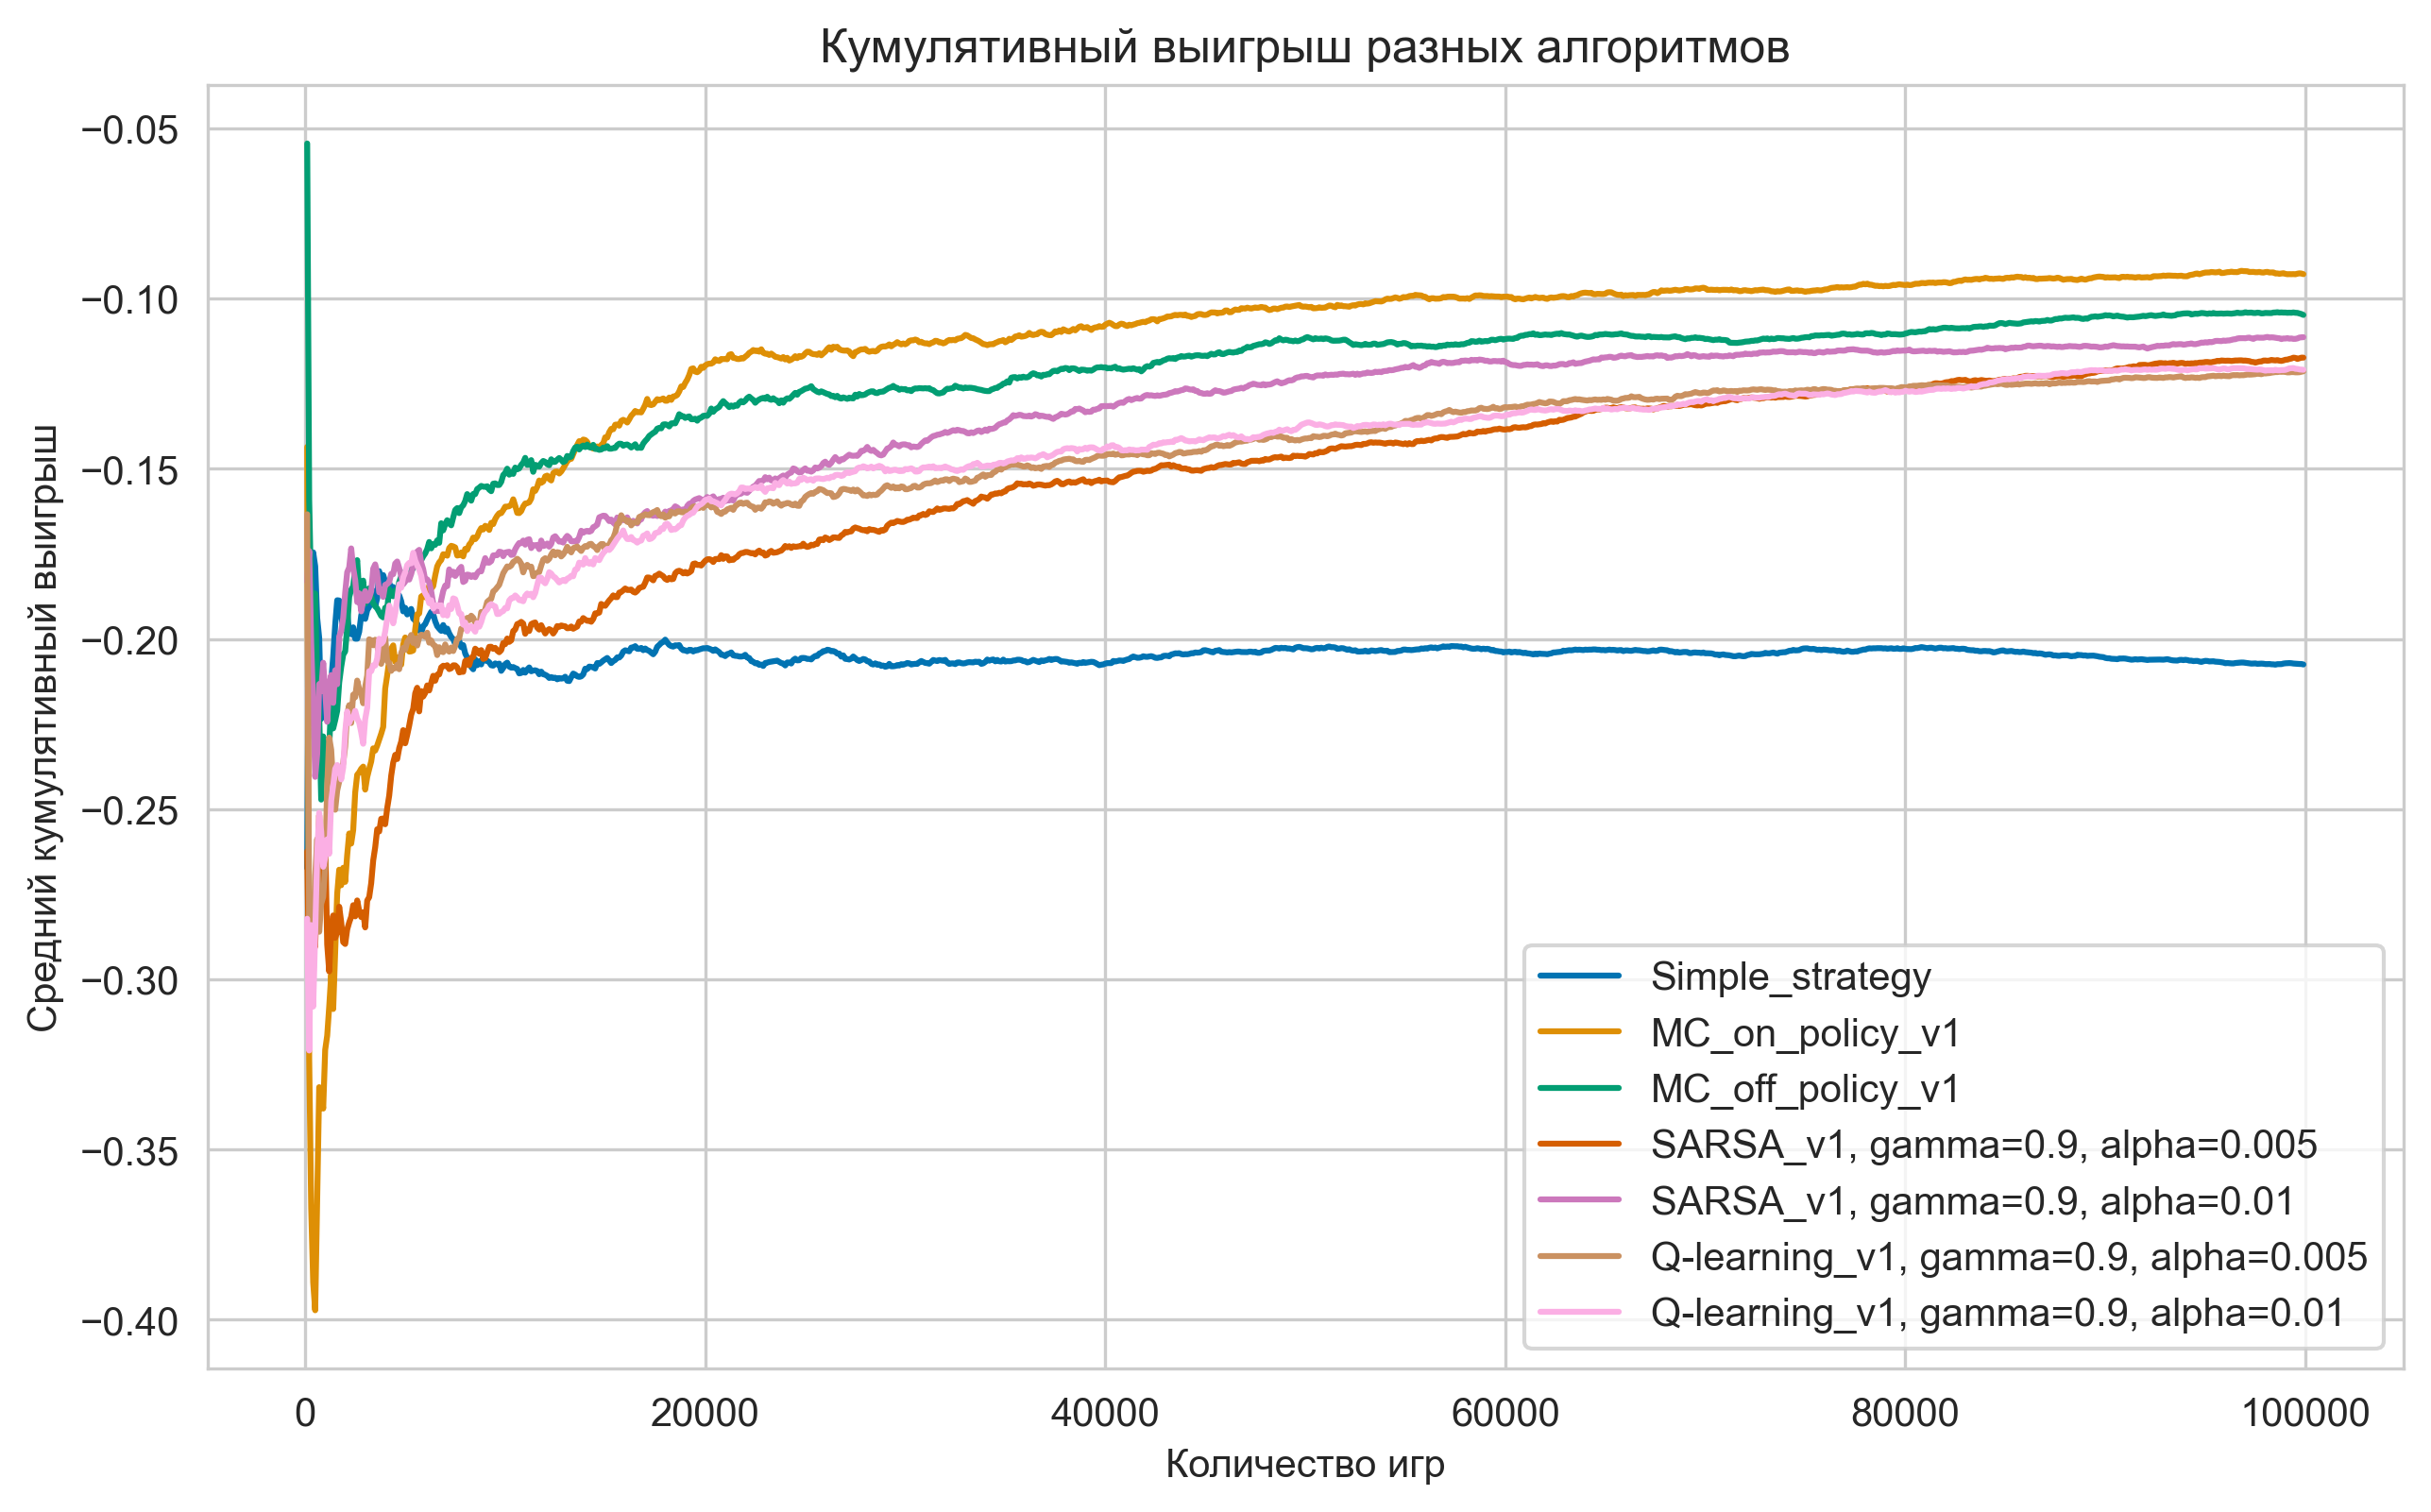

In [29]:
print_cum_avg_rewards(total_episodes = total_episodes, 
                      avg_reward_lists = [avg_reward_list,
                                          MC_on_avg_reward_list_v1,
                                          MC_off_avg_reward_list_v1,
                                          SARSA_avg_reward_list_v1,
                                          SARSA_avg_reward_list_new_v1,
                                          Qlearn_avg_reward_list_v1,
                                          Qlearn_avg_reward_list_new_v1,
                                          
                                         ], 
                      algo_names = ['Simple_strategy',
                                    'MC_on_policy_v1',
                                    'MC_off_policy_v1',
                                    'SARSA_v1, gamma=0.9, alpha=0.005',
                                    'SARSA_v1, gamma=0.9, alpha=0.01',
                                    'Q-learning_v1, gamma=0.9, alpha=0.005',
                                    'Q-learning_v1, gamma=0.9, alpha=0.01',
                                   ],
                      print_every = print_every
                     )

# Часть третья, в главной роли — Дастин Хоффман
    А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

    Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


## Task 6

In [30]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *


def cmp(a, b):
    return float(a > b) - float(a < b)


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_v2(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
        
        # adding counting cards
        self.cards_counter = 0
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.card_points = {
            1 : -1,
            2 : 1, 
            3 : 1, 
            4 : 1, 
            5 : 1, 
            6 : 1, 
            7 : 0, 
            8 : 0, 
            9 : 0, 
            10 : -1
        }
        
    def draw_card(self, np_random):
        card_num = np_random.choice(range(len(self.deck)))
        card = self.deck.pop(card_num)
        self.cards_counter += self.card_points[card]
        return card

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        
        elif action == 2:
            done = True
            # player takes card
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                # dealer takes cards
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_counter)

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        
        if len(self.deck) < 15:
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.cards_counter = 0
        
        return self._get_obs()
    

gym.envs.toy_text.blackjack.BlackjackEnv_v2 = BlackjackEnv_v2
if 'Blackjack-v2' in registry.env_specs:
    del registry.env_specs['Blackjack-v2']
    
register(
    id='Blackjack-v2',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnv_v2',
)

## Task 7

In [31]:
%%time
MC_on_Q_v2, MC_on_pi_v2, MC_on_avg_reward_list_v2 = MC_control_on_policy(env = gym.make('Blackjack-v2', natural=True), 
                                                                         init_episodes = 10, 
                                                                         total_episodes = total_episodes, 
                                                                         gamma = 0.1
                                                                        )

Building model using Mone-Carlo on policy control...
Step 99900/100000
Wall time: 4h 6min 36s


In [32]:
%%time
MC_off_Q_v2, MC_off_pi_v2, MC_off_avg_reward_list_v2 = MC_control_off_policy(env = gym.make('Blackjack-v2', natural=True), 
                                                                             total_episodes = total_episodes, 
                                                                             gamma = 0.1
                                                                            )

Building model using Mone-Carlo off policy control...
Step 99900/100000
Wall time: 17min 50s


In [33]:
%%time
SARSA_Q_v2, SARSA_pi_v2, SARSA_avg_reward_list_v2 = TD_on_policy_SARSA(env = gym.make('Blackjack-v2', natural=True), 
                                                                       total_episodes = total_episodes, 
                                                                       gamma = 0.1,
                                                                       alpha=0.005
                                                                      )

Building model using SARSA...
Step 100000/100000
Wall time: 18min 15s


In [34]:
%%time
Qlearn_Q_v2, Qlearn_pi_v2, Qlearn_avg_reward_list_v2 = TD_off_policy_Qlearning(env = gym.make('Blackjack-v2', natural=True), 
                                                                               total_episodes = total_episodes, 
                                                                               gamma = 0.1,
                                                                               alpha=0.005
                                                                              )

Building model Q-learning...
Step 100000/100000
Wall time: 25min 27s


In [35]:
%%time
SARSA_Q_new_v2, SARSA_pi_new_v2, SARSA_avg_reward_list_new_v2 = TD_on_policy_SARSA(env = gym.make('Blackjack-v2', natural=True), 
                                                                                   total_episodes = total_episodes, 
                                                                                   gamma = 0.1,
                                                                                   alpha=0.01
                                                                                  )

Building model using SARSA...
Step 100000/100000
Wall time: 26min 26s


In [36]:
%%time
Qlearn_Q_new_v2, Qlearn_pi_new_v2, Qlearn_avg_reward_list_new_v2 = TD_off_policy_Qlearning(env = gym.make('Blackjack-v2', natural=True), 
                                                                                           total_episodes = total_episodes, 
                                                                                           gamma = 0.1,
                                                                                           alpha=0.01
                                                                                          )

Building model Q-learning...
Step 100000/100000
Wall time: 28min 15s


Данные о среднем выигрыше по всем сыгранным 100000 играм
Simple_strategy: -0.207535
MC_on_policy_v2: -0.16864
MC_off_policy_v2: -0.161515
SARSA_v2, gamma=0.9, alpha=0.005: -0.182585
SARSA_v2, gamma=0.9, alpha=0.01: -0.17555
Q-learning_v2, gamma=0.9, alpha=0.005: -0.192035
Q-learning_v2, gamma=0.9, alpha=0.01: -0.18367


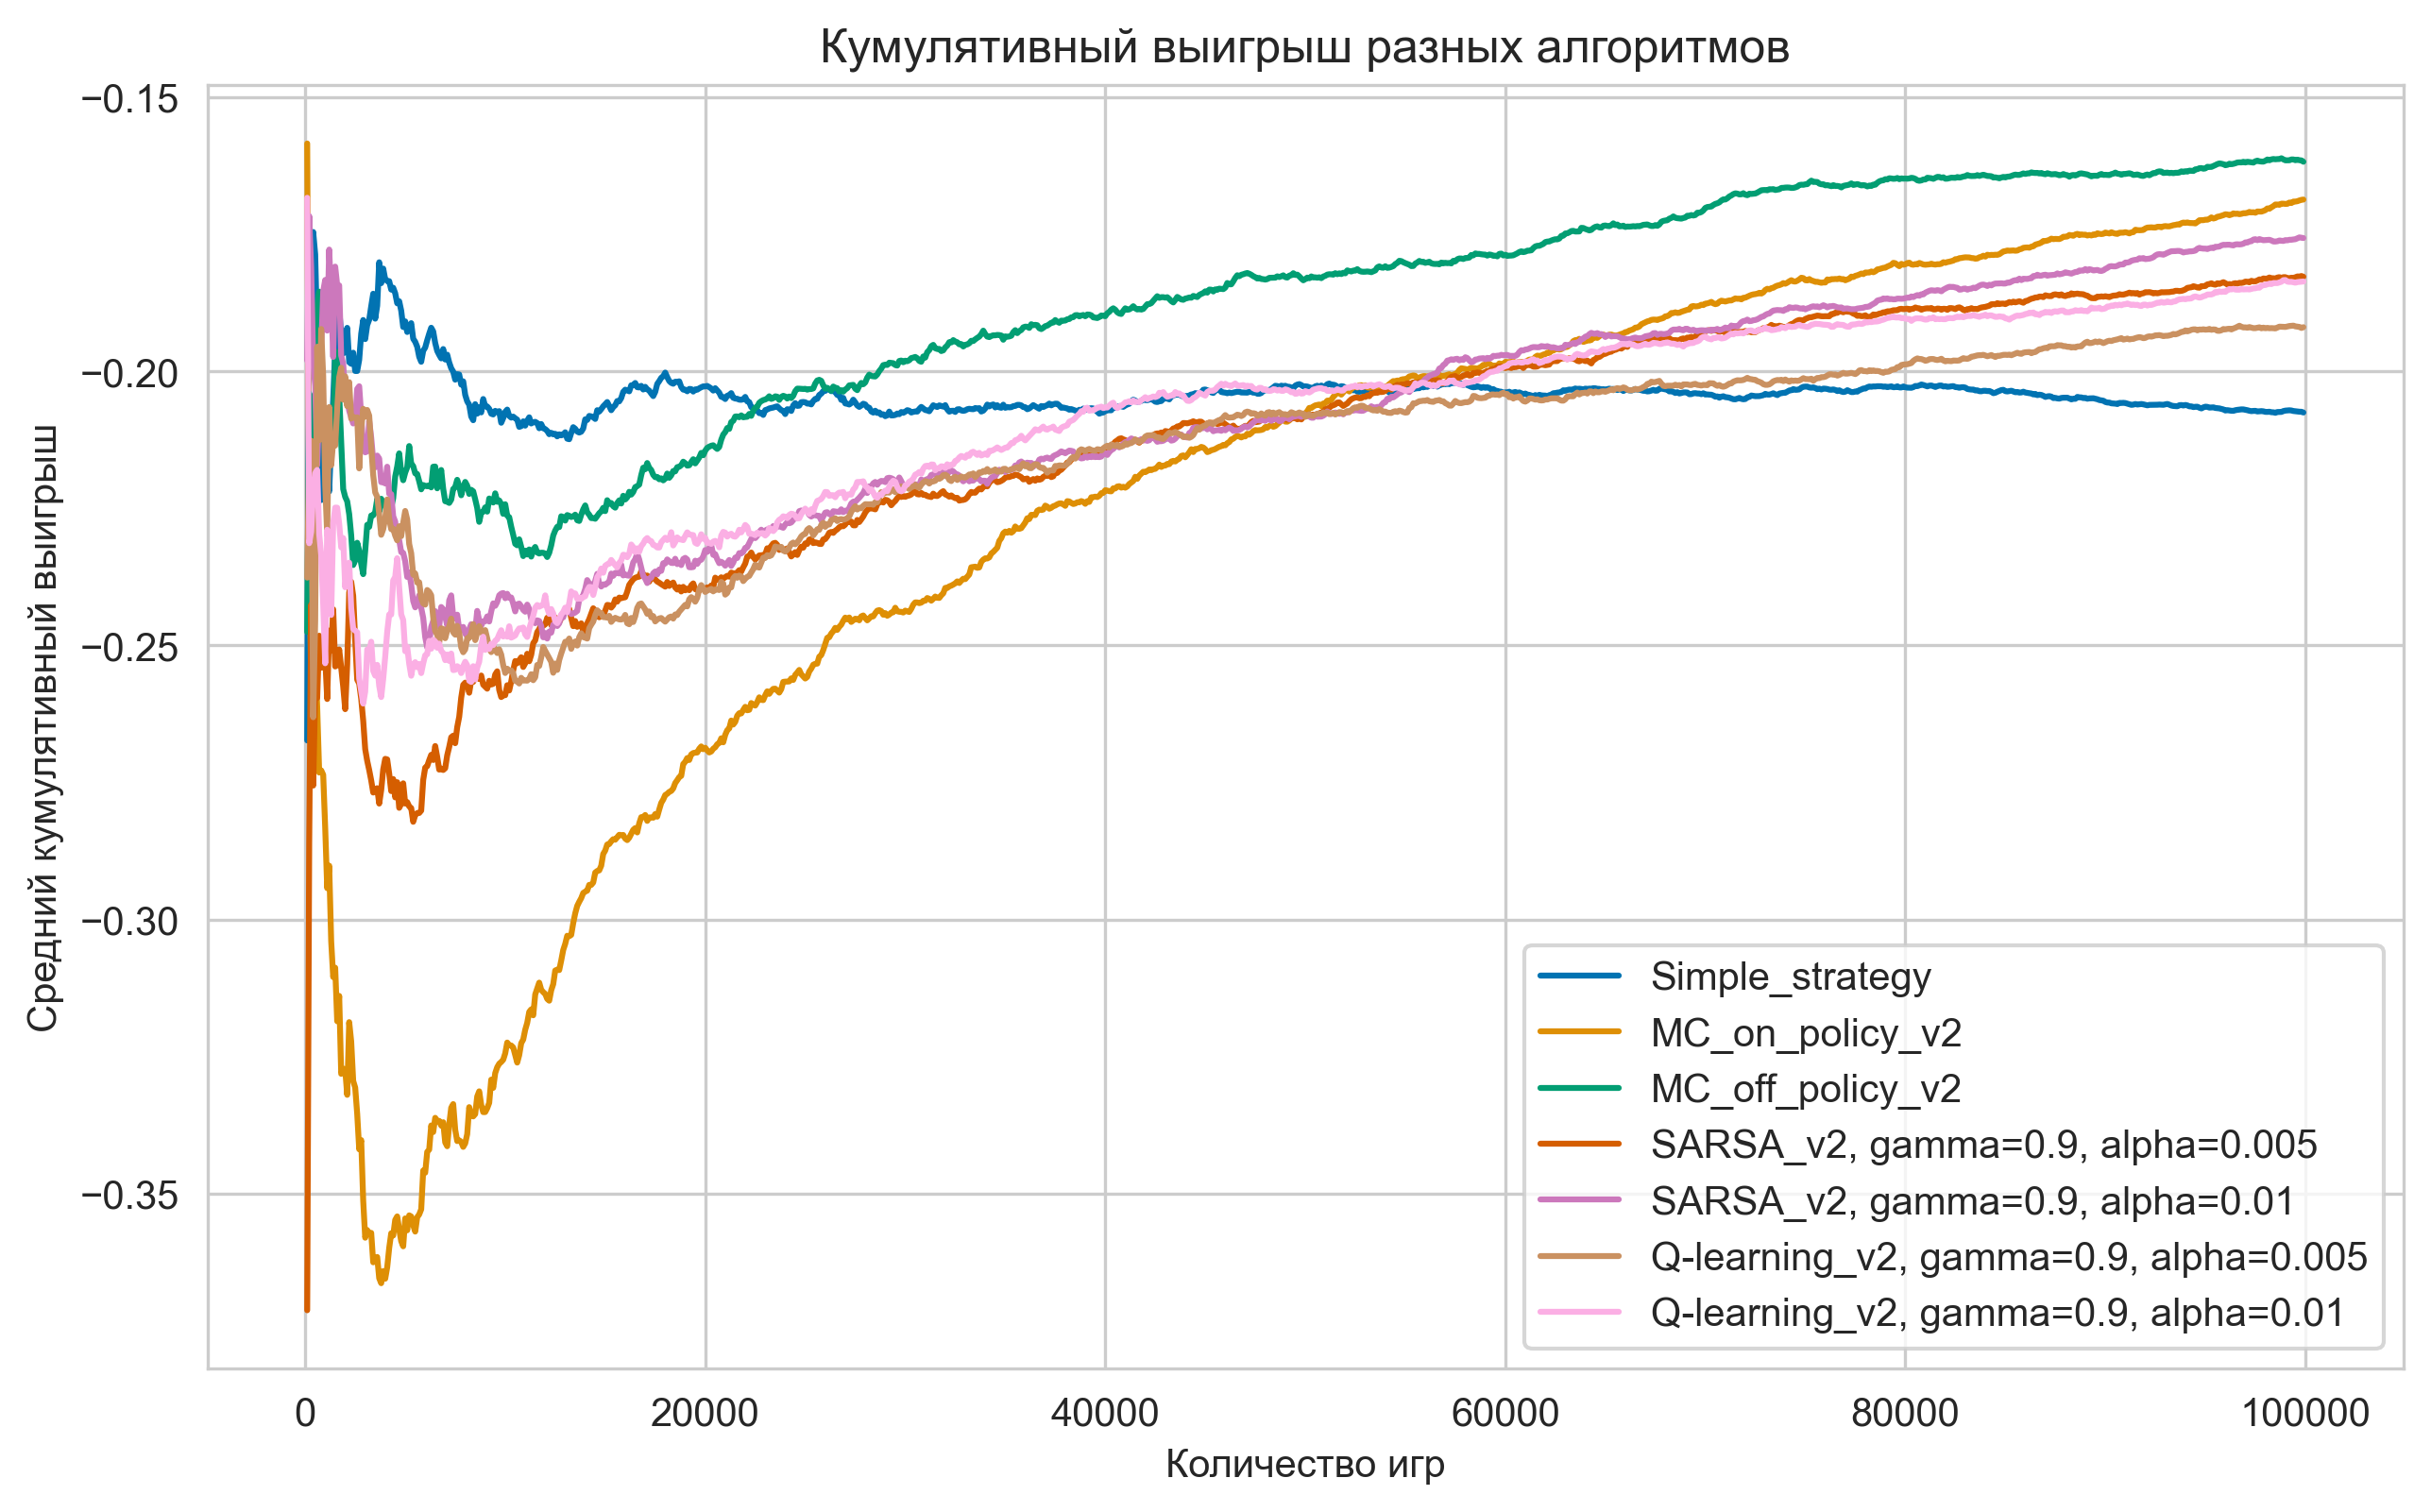

In [37]:
print_cum_avg_rewards(total_episodes = total_episodes, 
                      avg_reward_lists = [avg_reward_list,
                                          MC_on_avg_reward_list_v2,
                                          MC_off_avg_reward_list_v2,
                                          SARSA_avg_reward_list_v2,
                                          SARSA_avg_reward_list_new_v2,
                                          Qlearn_avg_reward_list_v2,
                                          Qlearn_avg_reward_list_new_v2,
                                          
                                         ], 
                      algo_names = ['Simple_strategy',
                                    'MC_on_policy_v2',
                                    'MC_off_policy_v2',
                                    'SARSA_v2, gamma=0.9, alpha=0.005',
                                    'SARSA_v2, gamma=0.9, alpha=0.01',
                                    'Q-learning_v2, gamma=0.9, alpha=0.005',
                                    'Q-learning_v2, gamma=0.9, alpha=0.01',
                                   ],
                      print_every = print_every
                     )